#Import Packages

In [ ]:
!pip install torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Subset

import torchvision
from torchvision import datasets
from torchvision.datasets import DatasetFolder
import torchvision.transforms as transforms

# This is for the progress bar
from tqdm.auto import tqdm
# This is for ploting
import matplotlib.pyplot as plt

#Dataset

#Download the food-11 image dataset

In [ ]:
# Install a package to download data from Kaggle
!pip install -q opendatasets

In [ ]:
import opendatasets as od
import pandas as pd

od.download('https://www.kaggle.com/datasets/trolukovich/food11-image-dataset') # insert ypu kaggle username and key

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mmesomanwanejuafor
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/trolukovich/food11-image-dataset


100%|██████████| 1.08G/1.08G [00:32<00:00, 35.7MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Pytorch Dataset and Downloader

In [ ]:
train_transform = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 224)
    transforms.Resize((224, 224)),
    # You may add some transforms here.
    # ToTensor() should be the last one of the transforms.
    transforms.ToTensor(),
])

# We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

#Data Augmentation

In [ ]:
# Define data transforms for data augmentation
data_transforms = transforms.Compose([
    transforms.Resize(256),  # Resize the input images to a square of size 256x256
    transforms.RandomHorizontalFlip(),  # Randomly flip the input images horizontally
    transforms.RandomRotation(20),  # Randomly rotate the input images by 10 degrees
    transforms.RandomCrop(224),  # Randomly crop a square of size 224x224 from the input images
    transforms.ToTensor(),  # Convert the input images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the input images
    transforms.RandomErasing(),
    transforms.ColorJitter(0.1, 0.1, 0.1)
    ])

# Apply data augmentation to the training dataset
train_dataset = datasets.ImageFolder("food11-image-dataset/training", transform=data_transforms)


# Splitting the Dataset

In [ ]:
# Construct datasets.
train_dataset = datasets.ImageFolder("food11-image-dataset/training", transform=train_transform)
eval_dataset = datasets.ImageFolder("food11-image-dataset/evaluation", transform=test_transform)
val_dataset = datasets.ImageFolder("food11-image-dataset/validation", transform=val_transform)

# Define the desired ratio for train and evaluation data (e.g., 90% train, 10% evaluation)
train_ratio = 0.9
val_ratio = 1 - train_ratio

# Calculate the sizes of train and evaluation datasets based on the ratios
train_size = int(train_ratio * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split the train dataset into train and evaluation subsets
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

print(f'Original train set has {len(train_dataset)} samples')
print(f'Train set has {len(train_subset)} samples')
print(f'Validation set has {len(val_subset)} samples')
print(f'Evaluation set has {len(eval_dataset)} samples')

Original train set has 9866 samples
Train set has 8879 samples
Validation set has 987 samples
Evaluation set has 3347 samples


In [ ]:
# Batch size for training, validation, and testing.
# A greater batch size usually gives a more stable gradient.
# But the GPU memory is limited, so please adjust it carefully.
batch_size = 32

# Construct data loaders
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)

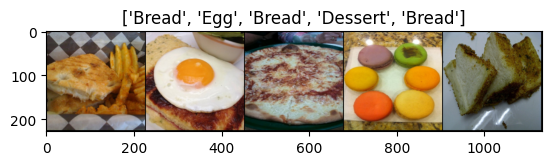

In [ ]:
# show some samples
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
train_loader_for_vis = DataLoader(train_subset, batch_size=5, shuffle=True, num_workers=0)
inputs, classes = next(iter(train_loader_for_vis))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

class_names = ['Bread', 'Diary product', 'Dessert', 'Egg', 'Fried food', 'Meat' 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit']

imshow(out, title=[class_names[x] for x in classes])

#Models

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
class MyVGG16(nn.Module):
    def __init__(self):
        super(MyVGG16, self).__init__()

        # Load the pre-trained VGG16 model
        vgg16 = models.vgg16(pretrained=True)

        # Extract only the convolutional layers from the pre-trained VGG16 model
        self.features = vgg16.features

        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 11)  # Output layer with 11 classes
        )

    def forward(self, x):

        # Extract features using VGG16's convolutional layers
        x = self.features(x)

        # Flatten the feature map
        x = x.view(x.size(0), -1)

        # Pass through fully connected layers
        x = self.fc_layers(x)

        return x

In [ ]:

# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

#Initialize a model, and put it on the device specified.
vgg_model = MyVGG16()
vgg_model = vgg_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Define Loss and Optimizer

In [ ]:
import torch.optim as optim

In [ ]:
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(vgg_model.parameters(), lr=0.0003)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
#optimizer = torch.optim.SGD(vgg_model.parameters(), lr=0.0003)

#Train and Validation

In [ ]:
# The number of training epochs.
n_epochs = 15

# These are used to record information
best_valid_acc = 0
train_loss_epochs = []
train_acc_epochs = []
valid_loss_epochs = []
valid_acc_epochs = []

for epoch in range(n_epochs):

    vgg_model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = vgg_model(imgs)

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels)

        # Compute the gradients for parameters.
        loss.backward()

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc.item())

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_loss_epochs.append(train_loss)
    train_acc_epochs.append(train_acc)

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    vgg_model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
          logits = vgg_model(imgs)

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels)

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc.item())

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_loss_epochs.append(valid_loss)
    valid_acc_epochs.append(valid_acc)

    # save the best model
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(vgg_model.state_dict(), 'best_model.pth')

    # Print the information.
    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Train: loss={train_loss:.5f}, acc={train_acc:.5f} | Valid: loss={valid_loss:.5f}, acc={valid_acc:.5f}")

  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

[Epoch: 001/015] Train: loss=2.30229, acc=0.19758 | Valid: loss=2.21395, acc=0.23436


  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

[Epoch: 002/015] Train: loss=2.10766, acc=0.28010 | Valid: loss=1.96074, acc=0.37082


  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

[Epoch: 003/015] Train: loss=1.78505, acc=0.40186 | Valid: loss=1.43699, acc=0.57210


  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

[Epoch: 004/015] Train: loss=1.37881, acc=0.53623 | Valid: loss=1.05939, acc=0.66831


  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

[Epoch: 005/015] Train: loss=1.11195, acc=0.62513 | Valid: loss=0.88972, acc=0.71203


  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

[Epoch: 006/015] Train: loss=0.94299, acc=0.67970 | Valid: loss=0.78242, acc=0.74630


  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

[Epoch: 007/015] Train: loss=0.82547, acc=0.72545 | Valid: loss=0.71722, acc=0.75758


  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

[Epoch: 008/015] Train: loss=0.73808, acc=0.75097 | Valid: loss=0.66222, acc=0.77856


  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

[Epoch: 009/015] Train: loss=0.66067, acc=0.78175 | Valid: loss=0.62299, acc=0.79159


  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

[Epoch: 010/015] Train: loss=0.60807, acc=0.79874 | Valid: loss=0.60741, acc=0.80048


  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

[Epoch: 011/015] Train: loss=0.55554, acc=0.81875 | Valid: loss=0.58008, acc=0.80414


  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

[Epoch: 012/015] Train: loss=0.51392, acc=0.82652 | Valid: loss=0.57045, acc=0.80451


  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

[Epoch: 013/015] Train: loss=0.46890, acc=0.84741 | Valid: loss=0.55085, acc=0.79966


  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

[Epoch: 014/015] Train: loss=0.43582, acc=0.85732 | Valid: loss=0.57011, acc=0.81131


  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

[Epoch: 015/015] Train: loss=0.41100, acc=0.86497 | Valid: loss=0.53267, acc=0.81459


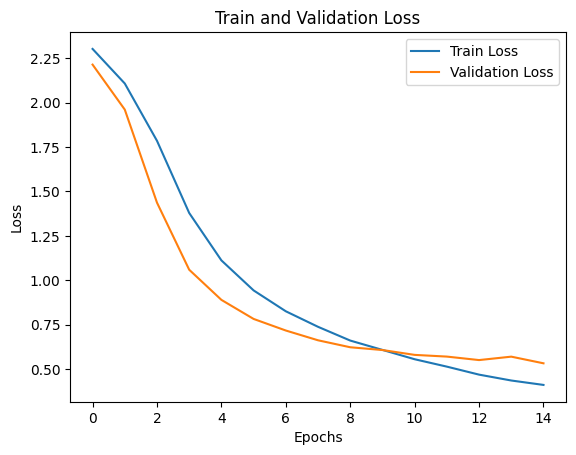

In [ ]:
# Plotting the loss curves
plt.figure()
plt.plot(train_loss_epochs, label='Train Loss')
plt.plot(valid_loss_epochs, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

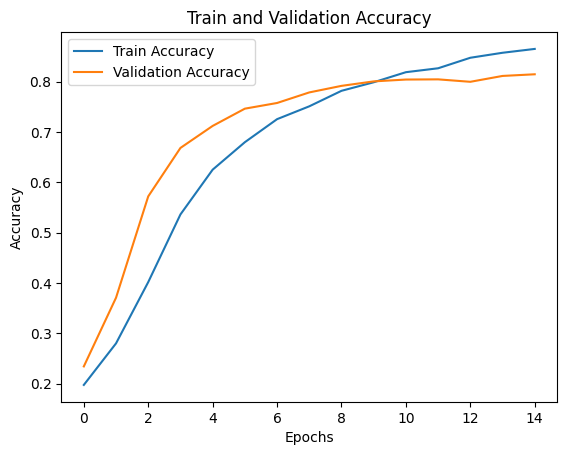

In [ ]:
# Plotting the accuracy curves
plt.figure()
plt.plot(train_acc_epochs, label='Train Accuracy')
plt.plot(valid_acc_epochs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

# Testing

In [ ]:
# load best model weights
vgg_model.load_state_dict(torch.load('best_model.pth'))

# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
vgg_model.eval()

test_accs = []

# Iterate the testing set by batches.
for batch in tqdm(eval_loader):
    # A batch consists of image data and corresponding labels.
    imgs, labels = batch
    imgs = imgs.to(device)
    labels = labels.to(device)

    # We don't need gradient in test
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
      logits = vgg_model(imgs)

    # We can still compute the loss (but not the gradient).
    loss = criterion(logits, labels)

    # Compute the accuracy for current batch.
    acc = (logits.argmax(dim=-1) == labels).float().mean()

    # Record accuracy.
    test_accs.append(acc)

# The average accuracy for entire test set is the average of the recorded values.
test_acc = sum(test_accs) / len(test_accs)
print(f'Test accuracy {test_acc}')

  0%|          | 0/105 [00:00<?, ?it/s]

Test accuracy 0.848308265209198


#Model 2: Resnet34

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class MyResNet34(nn.Module):
    def __init__(self):
        super(MyResNet34, self).__init__()

        # Load the pre-trained ResNet-34 model
        resnet34 = models.resnet34(weights='IMAGENET1K_V1')

        self.features = nn.Sequential(*list(resnet34.children())[:-1])

        # Define your custom fully connected layer for classification
        self.fc_layers = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(128, 11)  # Output layer with 11 classes
        )

    def forward(self, x):
        # Extract features using ResNet-34
        x = self.features(x)

        # Flatten the feature map
        x = x.view(x.size(0), -1)

        # Pass through fully connected layers
        x = self.fc_layers(x)

        return x

model_2 = MyResNet34()


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class MyResNet34(nn.Module):
    def __init__(self):
        super(MyResNet34, self).__init__()

        # Load the pre-trained ResNet-34 model
        resnet34 = models.resnet34(pretrained=True)

        self.features = nn.Sequential(*list(resnet34.children())[:-1])

        # Define your custom fully connected layer for classification
        self.fc_layers = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(128, 11)  # Output layer with 11 classes
        )

    def forward(self, x):

        # Extract features using ResNet-34
        x = self.features(x)

        # Flatten the feature map
        x = x.view(x.size(0), -1)

        # Pass through fully connected layers
        x = self.fc_layers(x)

        return x

In [ ]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

#Initialize a model, and put it on the device specified.
model_2 = MyResNet34()
model_2 = model_2.to(device)


#Define loss and Optimizers

In [ ]:
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()
# Initialize optimizer for ResNet model
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.001, momentum=0.9)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

#Training and Validation

In [ ]:
# Early stopping criteria
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

early_stopping = EarlyStopping(patience=5)

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
# The number of training epochs.
n_epochs = 15

# These are used to record information
best_valid_acc = 0
train_loss_epochs = []
train_acc_epochs = []
valid_loss_epochs = []
valid_acc_epochs = []

for epoch in range(n_epochs):

    model_2.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model_2(imgs)

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels)

        # Compute the gradients for parameters.
        loss.backward()

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc.item())

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_loss_epochs.append(train_loss)
    train_acc_epochs.append(train_acc)

    model_2.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model_2(imgs)

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels)

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc.item())

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_loss_epochs.append(valid_loss)
    valid_acc_epochs.append(valid_acc)

    # save the best model
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model_2.state_dict(), 'best_model.pth')

    # Print the information.
    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Train: loss={train_loss:.5f}, acc={train_acc:.5f} | Valid: loss={valid_loss:.5f}, acc={valid_acc:.5f}")


  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

[Epoch: 001/015] Train: loss=2.08314, acc=0.26743 | Valid: loss=1.54840, acc=0.53734


  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

[Epoch: 002/015] Train: loss=1.29181, acc=0.57652 | Valid: loss=0.78468, acc=0.75373


  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

[Epoch: 003/015] Train: loss=0.77331, acc=0.75375 | Valid: loss=0.52912, acc=0.84043


  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

[Epoch: 004/015] Train: loss=0.47093, acc=0.86203 | Valid: loss=0.41302, acc=0.86499


  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

[Epoch: 005/015] Train: loss=0.30337, acc=0.91343 | Valid: loss=0.43497, acc=0.87388


  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

[Epoch: 006/015] Train: loss=0.21430, acc=0.93983 | Valid: loss=0.41697, acc=0.88094


  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

[Epoch: 007/015] Train: loss=0.14986, acc=0.95815 | Valid: loss=0.41893, acc=0.89542


  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

[Epoch: 008/015] Train: loss=0.11848, acc=0.96716 | Valid: loss=0.48140, acc=0.88975


  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

[Epoch: 009/015] Train: loss=0.09040, acc=0.97673 | Valid: loss=0.52405, acc=0.87168


  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

[Epoch: 010/015] Train: loss=0.08942, acc=0.97402 | Valid: loss=0.50931, acc=0.87646


  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

[Epoch: 011/015] Train: loss=0.08529, acc=0.97648 | Valid: loss=0.53949, acc=0.88717


  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

[Epoch: 012/015] Train: loss=0.06302, acc=0.98267 | Valid: loss=0.57969, acc=0.87810


  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

[Epoch: 013/015] Train: loss=0.05189, acc=0.98638 | Valid: loss=0.51106, acc=0.89561


  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

[Epoch: 014/015] Train: loss=0.04283, acc=0.98918 | Valid: loss=0.59293, acc=0.88370


  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

[Epoch: 015/015] Train: loss=0.04480, acc=0.98581 | Valid: loss=0.58294, acc=0.88754


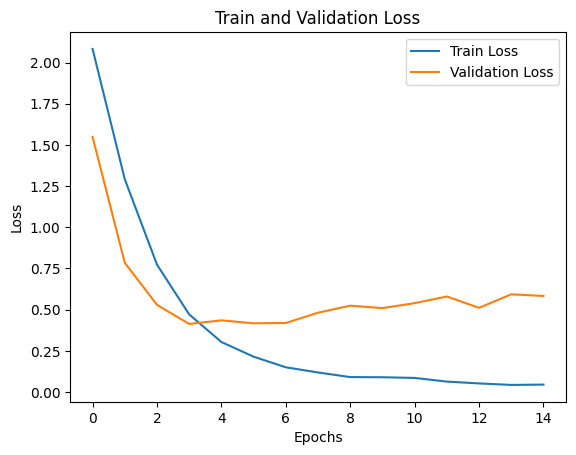

In [ ]:
import matplotlib.pyplot as plt

# Plotting the loss curves
plt.figure()
plt.plot(train_loss_epochs, label='Train Loss')
plt.plot(valid_loss_epochs, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()


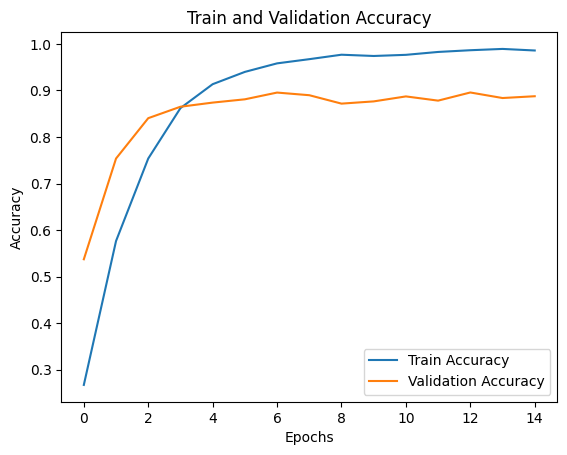

In [ ]:
# Plotting the accuracy curves
plt.figure()
plt.plot(train_acc_epochs, label='Train Accuracy')
plt.plot(valid_acc_epochs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

#Testing

In [ ]:
# Load best model weights
model_2.load_state_dict(torch.load('best_model.pth'))

# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
model_2.eval()

test_accs = []

# Iterate the testing set by batches.
for batch in tqdm(eval_loader):
    # A batch consists of image data and corresponding labels.
    imgs, labels = batch
    imgs = imgs.to(device)
    labels = labels.to(device)

    # We don't need gradient in test
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
        logits = model_2(imgs)

    # We can still compute the loss (but not the gradient).
    loss = criterion(logits, labels)

    # Compute the accuracy for the current batch.
    acc = (logits.argmax(dim=-1) == labels).float().mean()

    # Record accuracy.
    test_accs.append(acc)

# The average accuracy for the entire test set is the average of the recorded values.
test_acc = sum(test_accs) / len(test_accs)

print(f'Test accuracy: {test_acc}')


  0%|          | 0/105 [00:00<?, ?it/s]

Test accuracy: 0.9092262387275696


#AlexnetModel

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class MyAlexNet(nn.Module):
    def __init__(self):
        super(MyAlexNet, self).__init__()

        # Load the pre-trained AlexNet model
        alexnet = models.alexnet(pretrained=True)

        # Extract the features part of AlexNet
        self.features = alexnet.features

        # Define your custom fully connected layer for classification
        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 6 * 6, 512),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.Linear(256, 11)  # Output layer with 11 classes
        )

    def forward(self, x):
        # Extract features using AlexNet
        x = self.features(x)

        # Flatten the feature map
        x = x.view(x.size(0), -1)

        # Pass through fully connected layers
        x = self.fc_layers(x)

        return x

# Determine if CUDA is available and use it if possible
#device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize the model, and put it on the specified device
model_3 = MyAlexNet()
model_3 = model_3.to(device)


#Define loss and optimizers

In [ ]:
import torch.nn as nn
import torch.optim as optim

In [ ]:
# Define the loss function (Cross-Entropy Loss)
criterion = nn.CrossEntropyLoss()

# Initialize the optimizer for the AlexNet model
optimizer = optim.SGD(model_3.parameters(), lr=0.001)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)



#Training and Validation

In [ ]:
from tqdm import tqdm

# The number of training epochs
n_epochs = 15

# These are used to record information
best_valid_acc = 0
train_loss_epochs = []
train_acc_epochs = []
valid_loss_epochs = []
valid_acc_epochs = []

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model_3.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model_3(imgs)

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels)

        # Compute the gradients for parameters.
        loss.backward()

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc.item())

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_loss_epochs.append(train_loss)
    train_acc_epochs.append(train_acc)

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model_3.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model_3(imgs)

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels)

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc.item())

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_loss_epochs.append(valid_loss)
    valid_acc_epochs.append(valid_acc)

    # Save the best model
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model_3.state_dict(), 'best_model.pth')

    # Print the information.
    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Train: loss={train_loss:.5f}, acc={train_acc:.5f} | Valid: loss={valid_loss:.5f}, acc={valid_acc:.5f}")


100%|██████████| 31/31 [00:06<00:00,  4.66it/s]


[Epoch: 001/015] Train: loss=2.08790, acc=0.29412 | Valid: loss=1.69787, acc=0.49298


100%|██████████| 31/31 [00:06<00:00,  4.92it/s]


[Epoch: 002/015] Train: loss=1.49192, acc=0.49729 | Valid: loss=1.18365, acc=0.61275


100%|██████████| 31/31 [00:05<00:00,  5.72it/s]


[Epoch: 003/015] Train: loss=1.19862, acc=0.58884 | Valid: loss=1.02502, acc=0.66932


100%|██████████| 31/31 [00:05<00:00,  5.62it/s]


[Epoch: 004/015] Train: loss=1.05762, acc=0.63559 | Valid: loss=0.95381, acc=0.67428


100%|██████████| 31/31 [00:06<00:00,  4.95it/s]


[Epoch: 005/015] Train: loss=0.95367, acc=0.67922 | Valid: loss=0.93231, acc=0.68847


100%|██████████| 31/31 [00:05<00:00,  5.66it/s]


[Epoch: 006/015] Train: loss=0.87524, acc=0.70136 | Valid: loss=0.83887, acc=0.71367


100%|██████████| 31/31 [00:06<00:00,  4.84it/s]


[Epoch: 007/015] Train: loss=0.81674, acc=0.72286 | Valid: loss=0.82232, acc=0.72073


100%|██████████| 31/31 [00:05<00:00,  5.98it/s]


[Epoch: 008/015] Train: loss=0.75957, acc=0.74469 | Valid: loss=0.76768, acc=0.72973


100%|██████████| 31/31 [00:05<00:00,  5.65it/s]


[Epoch: 009/015] Train: loss=0.71512, acc=0.75916 | Valid: loss=0.76676, acc=0.72450


100%|██████████| 31/31 [00:05<00:00,  5.65it/s]


[Epoch: 010/015] Train: loss=0.67161, acc=0.77301 | Valid: loss=0.76709, acc=0.73036


100%|██████████| 31/31 [00:06<00:00,  4.90it/s]


[Epoch: 011/015] Train: loss=0.63438, acc=0.78809 | Valid: loss=0.70507, acc=0.75235


100%|██████████| 31/31 [00:05<00:00,  5.88it/s]


[Epoch: 012/015] Train: loss=0.59465, acc=0.79919 | Valid: loss=0.72958, acc=0.75833


100%|██████████| 31/31 [00:06<00:00,  4.86it/s]


[Epoch: 013/015] Train: loss=0.55827, acc=0.81404 | Valid: loss=0.72302, acc=0.75097


100%|██████████| 31/31 [00:05<00:00,  6.01it/s]


[Epoch: 014/015] Train: loss=0.52654, acc=0.82440 | Valid: loss=0.75121, acc=0.74429


100%|██████████| 31/31 [00:05<00:00,  5.49it/s]


[Epoch: 015/015] Train: loss=0.50305, acc=0.83200 | Valid: loss=0.66388, acc=0.77647


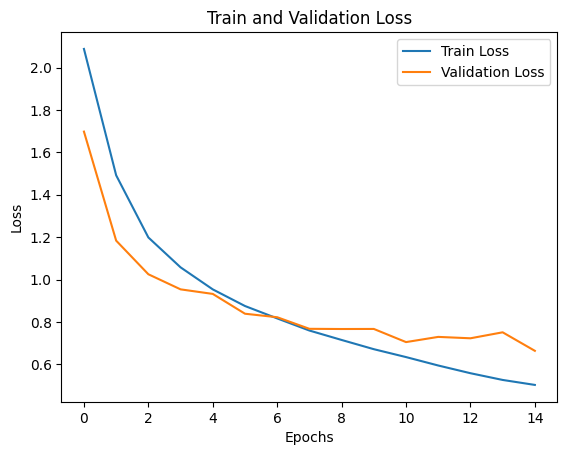

In [ ]:
# Plotting the loss curves
plt.figure()
plt.plot(train_loss_epochs, label='Train Loss')
plt.plot(valid_loss_epochs, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

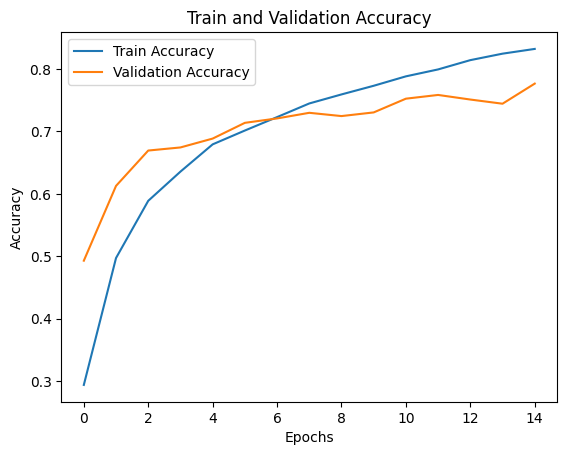

In [ ]:
# Plotting the accuracy curves
plt.figure()
plt.plot(train_acc_epochs, label='Train Accuracy')
plt.plot(valid_acc_epochs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()


In [ ]:
model_3.load_state_dict(torch.load('best_model.pth'))

model_3.eval()

test_accs = []

# Iterate the testing set by batches.
for batch in tqdm(eval_loader):

    imgs, labels = batch
    imgs = imgs.to(device)
    labels = labels.to(device)

    # We don't need gradient in test
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
        logits = model_3(imgs)


    loss = criterion(logits, labels)

    # Compute the accuracy for the current batch.
    acc = (logits.argmax(dim=-1) == labels).float().mean()

    # Record accuracy.
    test_accs.append(acc)

# The average accuracy for the entire test set is the average of the recorded values.
test_acc = sum(test_accs) / len(test_accs)

print(f'Test accuracy: {test_acc}')


100%|██████████| 105/105 [00:20<00:00,  5.19it/s]

Test accuracy: 0.7854167222976685


#Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
from sklearn.metrics import pair_confusion_matrix
import torch.nn.functional as F

vgg_model.eval()

all_predictions = []
all_labels = []

for batch in tqdm(eval_loader):

  images, labels = batch
  images = images.to(device)
  labels = labels.to(device)

  #forward pass
  with torch.no_grad():
    outputs = vgg_model(images)

    # Get predictions
    _, predicted = torch.max(outputs, 1)

    # Append predictions and labels to the lists
    all_predictions.extend(predicted.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

# Calculate confusion matrix
conf_matrix_vgg = confusion_matrix(all_labels, all_predictions)

100%|██████████| 105/105 [00:35<00:00,  2.93it/s]


#Resnet

In [ ]:
model_2.eval()

all_predictions = []
all_labels = []

for batch in tqdm(eval_loader):

  images, labels = batch
  images = images.to(device)
  labels = labels.to(device)

  #forward pass
  with torch.no_grad():
    outputs = model_2(images)

    _, predicted = torch.max(outputs, 1)

    all_predictions.extend(predicted.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

    conf_matrix_resnet = confusion_matrix(all_labels, all_predictions)

100%|██████████| 105/105 [00:27<00:00,  3.76it/s]


#Alexnet

In [ ]:
model_3.eval()

all_predictions = []
all_labels = []

for batch in tqdm(eval_loader):

  images, labels = batch
  images = images.to(device)
  labels = labels.to(device)

  #forward pass
  with torch.no_grad():
    outputs = model_3(images)

    _, predicted = torch.max(outputs, 1)

    all_predictions.extend(predicted.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

    conf_matrix_alexnet = confusion_matrix(all_labels, all_predictions)

100%|██████████| 105/105 [00:20<00:00,  5.02it/s]


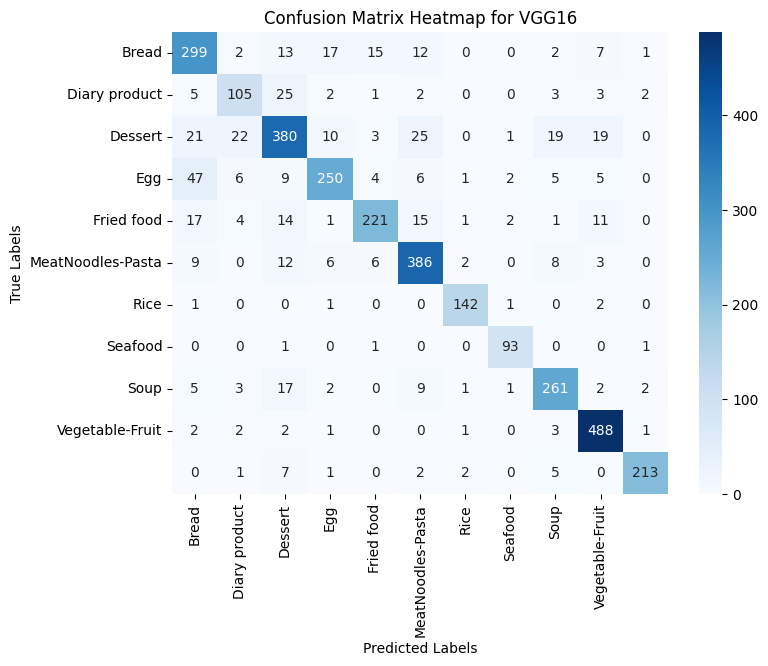

In [ ]:
import seaborn as sns
# Define function to plot confusion matrix heatmap
def plot_confusion_matrix(conf_matrix, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix Heatmap for {model_name}')
    plt.show()

# Plot confusion matrix heatmap for each model
plot_confusion_matrix(conf_matrix_vgg, 'VGG16')

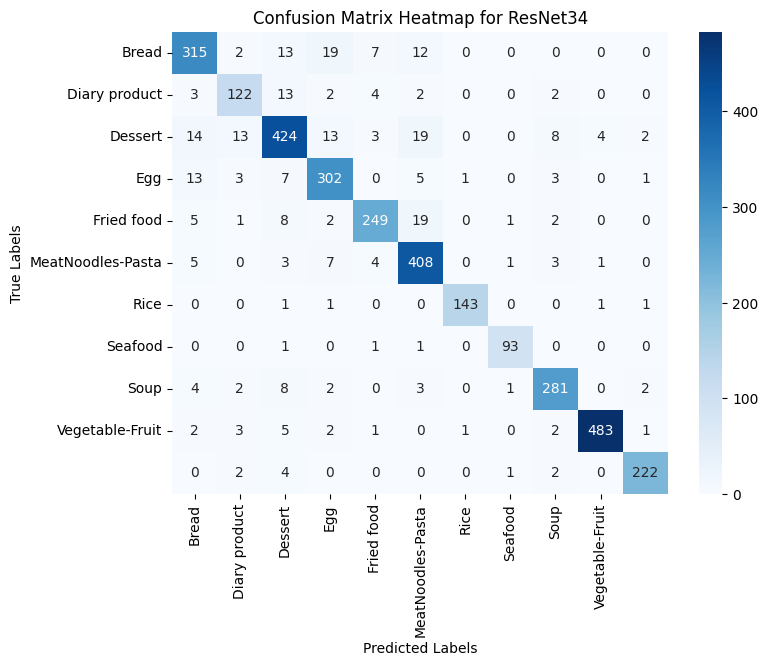

In [ ]:
plot_confusion_matrix(conf_matrix_resnet, 'ResNet34')

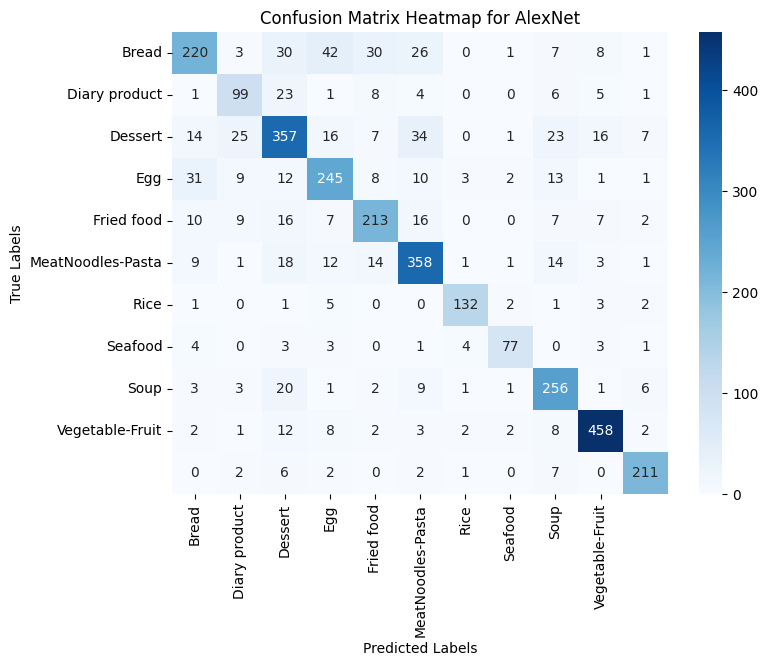

In [ ]:
plot_confusion_matrix(conf_matrix_alexnet, 'AlexNet')